In this competition, you are provided with a training set containing time-frequency data from two gravitational-wave interferometers (LIGO Hanford & LIGO Livingston). Each data sample contains either real or simulated noise and possibly a simulated continuous gravitational-wave signal (CW). The task is to identify when a signal is present in the data (target=1).


# 0) Import Libraries

In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
%matplotlib inline


from scipy import stats


from pathlib import Path
from scipy import stats
from tqdm.notebook import tqdm

# 1) Load and concat the labels

Load the training labels and load train and test data. We determine whether a data has gravitational is denoted by 1, 0 if none, and -1 if other.  

`dataset_file_mask` will be used for easy extraction of file path based on its `id`

In [25]:
DATA_PATH = Path('../input/g2net-detecting-continuous-gravitational-waves')
TRAIN_PATH = DATA_PATH/'train'
TEST_PATH = DATA_PATH/'test'
# df1 = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
df = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')

# df = pd.concat((df1, df2[df2.target!=-1]), ignore_index=True)

dataset_file_mask = ('../input/g2net-detecting-continuous-gravitational-waves/test/%s.hdf5',
                     '../input/g2net-detecting-continuous-gravitational-waves/train/%s.hdf5')
train_example_with_signal_path = TRAIN_PATH/'cc561e4fc.hdf5'
train_example_without_signal_path = TRAIN_PATH/'fb6db0d08.hdf5'

df1/sample submission is the probability between 0,1

In [18]:
df.head()

id  target
0  001121a05       1
1  004f23b2d       1
2  00a6db666       1
3  00f36a6ac       1
4  010a387db       1

In [17]:
# df2.head()

In [5]:
print("Df1 Shape (sample): ",df1.shape) 
print("Df2 Shape (training label): ",df2.shape)
print("Combined Dataset Shape : ",df.shape)

Df1 Shape (sample):  (7975, 2)
Df2 Shape (training label):  (603, 2)
Combined Dataset Shape :  (8575, 2)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


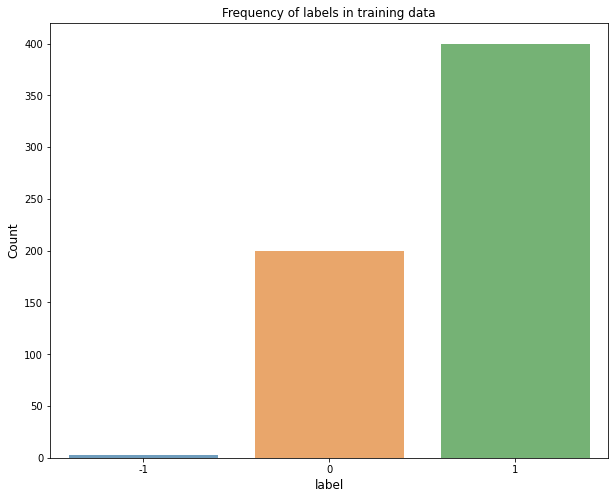

In [19]:
label_count  = df['target'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(label_count.index, label_count.values, alpha=0.7)
plt.title(f'Frequency of labels in training data', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('label', fontsize=12)
plt.show()

# 2) Load the hdf5 file
The function below loads the data and also performs some moving average (MA) to reduce the noise

In [6]:
def get_MA_SFT(n, MA=12):
    # Load `id` and `target` from dataframe
    id = df.iloc[n]['id']
    target = df.iloc[n]['target']

    # Get the hdf5 file name
    fname = dataset_file_mask[int(target!=0.5)] % id

    # Read the data from the file
    data = h5py.File(fname, 'r')[id]

    freqs = np.array(data['frequency_Hz'])
    ma_sft = {}
    for detector in ['L1', 'H1']:
        # Get the SFT values
        sft = np.array(data[detector]['SFTs'])*1e22

        # Transform them into power spectrum values
        power = np.power(np.abs(sft), 2)

        # Now calculate the moving average in every `MA` time points
        # For this we get the `cumsum` along the time axis and substract for every `MA` time points
        # The last block may not contain `MA` points, and it is ignored
        power_ma_cumsum = np.cumsum(power, axis=1)
        power_ma_cumsum_0 = np.concatenate((np.zeros((power.shape[0],1)), power_ma_cumsum), axis=1)[:,::MA]
        power_ma = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/MA
        ma_sft[detector] = power_ma
        
    return ma_sft, freqs

In [7]:
get_MA_SFT(0, MA = 12)

({'L1': array([[2.78080718, 2.74806817, 1.68772697, ..., 1.7578125 , 4.3922526 ,
          2.20898438],
         [1.85113144, 2.4553709 , 1.24435647, ..., 2.13574219, 2.39208984,
          1.95458984],
         [1.7920564 , 2.25244395, 1.08123239, ..., 3.33740234, 2.86971029,
          1.86889648],
         ...,
         [2.23781951, 1.64585479, 2.40049903, ..., 2.07568359, 2.40193685,
          1.85245768],
         [1.63601335, 1.99318314, 1.52731609, ..., 3.21264648, 3.17244466,
          1.30297852],
         [2.34311612, 1.96948274, 4.11073081, ..., 2.0218099 , 3.41772461,
          2.22810872]]),
  'H1': array([[2.41098086, 1.80256049, 2.68547853, ..., 1.77587891, 1.73958333,
          1.27579753],
         [3.17803129, 1.96097024, 2.25210349, ..., 2.14282227, 1.85424805,
          1.65340169],
         [3.16080411, 2.43968264, 1.24435298, ..., 1.94913737, 2.8754069 ,
          2.27140299],
         ...,
         [2.44937865, 2.76649443, 1.03155518, ..., 2.64453125, 1.99527995,
 

# 3) Testing some of the records

The idea of the testing is to plot the average values of SFT with respect both to the frequency or to the time axis. 
Then we do the statistical test, whether or not the achieved values satisfy the normal distribution.

Our null hypothesis will be 'the record is a white gaussian noise'. We calculate the corresponding p-values. If they are suffisiently low, we reject the null hypothesis and say, that the signal is not gaussian. So we must pay attention to it.

In [8]:
def test_record_view(id):
    # SFT with MA
    ma_sft, freqs = get_MA_SFT(id)

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
    ax_names = ('Interval No', 'Frequency, Hz')
    for col, detector in enumerate(['L1', 'H1']):
        # Prepare the axes
        axs[0, col].set_title(f'Detector={detector}')
        axs[0, col].set_xlabel(ax_names[0])
        axs[0, col].set_ylabel(ax_names[1])
        axs[0, col].pcolormesh(range(ma_sft[detector].shape[1]), freqs, ma_sft[detector])

        for row in range(2):
            # Calculate mean value for each frequency or for each time interval
            x = np.mean(ma_sft[detector], axis=row)
            k2, p = stats.normaltest(x)

            axs[row+1, col].set_title(f'Detector={detector}; p-value={p:.3}')
            axs[row+1, col].set_xlabel(ax_names[row])
            if row==0:
                axs[row+1, col].plot(x)
            else:
                axs[row+1, col].plot(freqs, x)
                
    fig.tight_layout(pad=1.5)
    plt.show()

In [9]:
ids = df.index[df['target'] == 0].tolist()
print(ids)

[7982, 7986, 7988, 7995, 7998, 8006, 8011, 8012, 8016, 8017, 8018, 8019, 8022, 8023, 8024, 8029, 8030, 8031, 8036, 8042, 8044, 8047, 8048, 8049, 8052, 8056, 8063, 8064, 8065, 8066, 8075, 8076, 8081, 8084, 8085, 8086, 8087, 8091, 8092, 8094, 8096, 8098, 8099, 8100, 8102, 8103, 8105, 8107, 8113, 8115, 8117, 8119, 8120, 8125, 8129, 8132, 8139, 8150, 8152, 8155, 8159, 8160, 8165, 8175, 8176, 8177, 8185, 8188, 8191, 8195, 8196, 8197, 8199, 8205, 8209, 8213, 8215, 8216, 8218, 8219, 8239, 8241, 8246, 8247, 8251, 8252, 8253, 8254, 8256, 8257, 8259, 8261, 8263, 8269, 8270, 8272, 8278, 8279, 8281, 8283, 8285, 8288, 8291, 8295, 8298, 8301, 8308, 8310, 8315, 8317, 8325, 8328, 8329, 8332, 8337, 8341, 8343, 8346, 8347, 8350, 8351, 8353, 8354, 8358, 8359, 8372, 8374, 8375, 8377, 8382, 8383, 8387, 8388, 8393, 8395, 8396, 8402, 8405, 8406, 8410, 8411, 8412, 8417, 8420, 8422, 8424, 8426, 8427, 8428, 8430, 8431, 8435, 8437, 8438, 8439, 8441, 8442, 8443, 8445, 8450, 8454, 8464, 8466, 8467, 8469, 8482, 848

## 3.1) `id`=7982

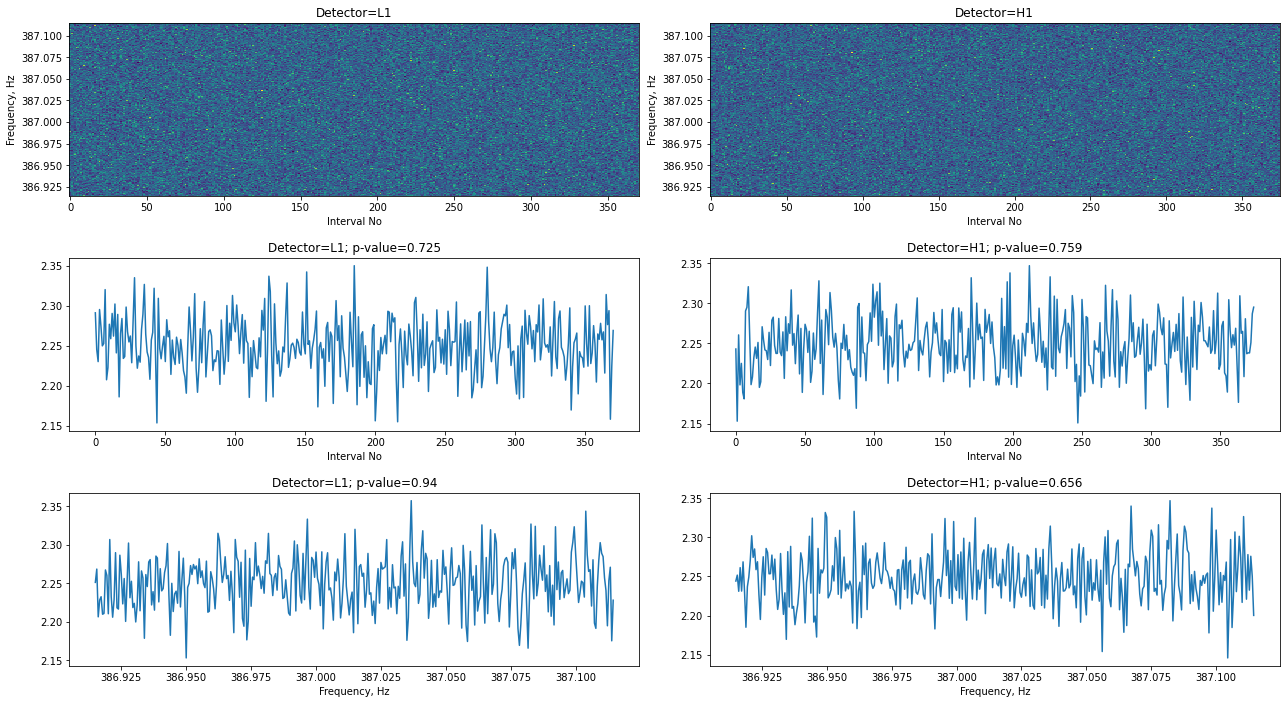

In [10]:
test_record_view(id=7982)

## 3.1) `id`=609

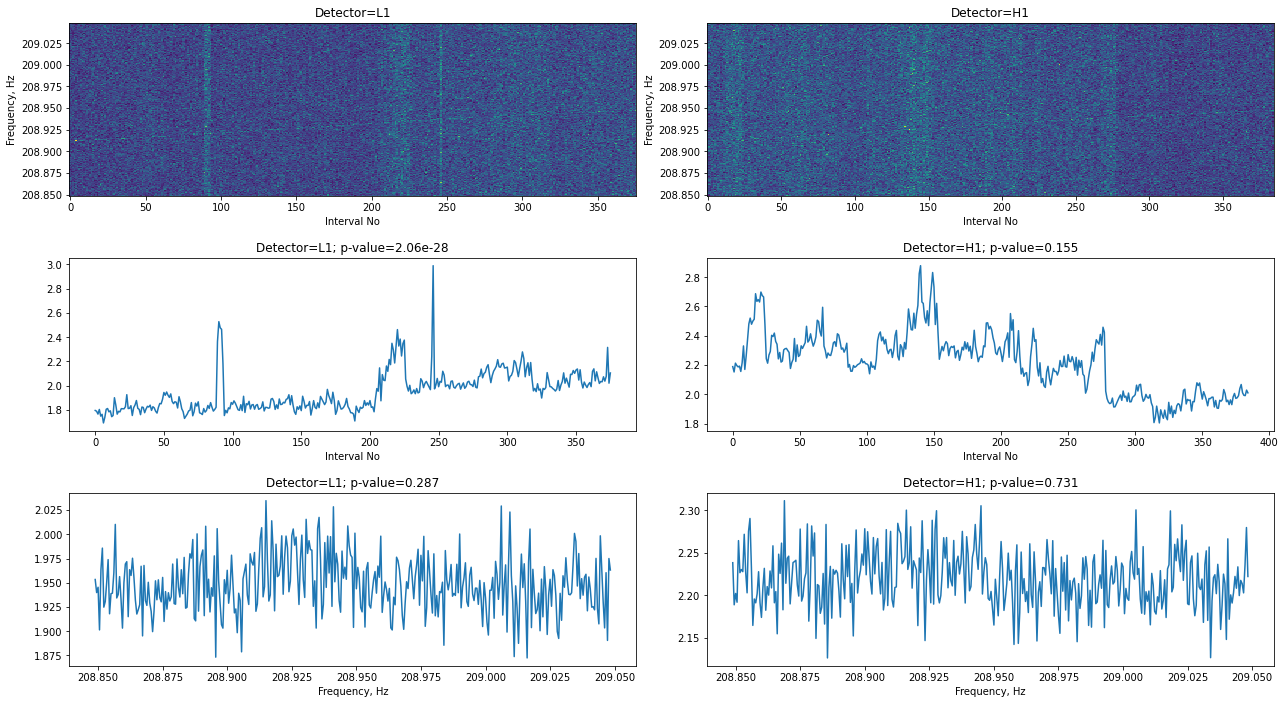

In [11]:
test_record_view(id=609)

* It can be seen from the upper two graphs, that this record does contain the signal. At the same time the noise is not stationary.
* From the middle two graphs we can also see, that the noise is not stationary.
  P-value is low (2e-28) only for the left graph. For the right it is not so low (0.155), that we can reject the null hypothesis.
* From the bottom graphs we can say, it looks like white noise, and the corresponding p-values (0.287 and 0.731) are high.

Conclusion: **the record has non-gaussian noise background and may or may not contain a signal. We must pay attention to it.**

Of course, we can see the signal on the upper graphs by our eyes, but the used statistical criteria is rather weak for this))

## 3.2) `id`=7850

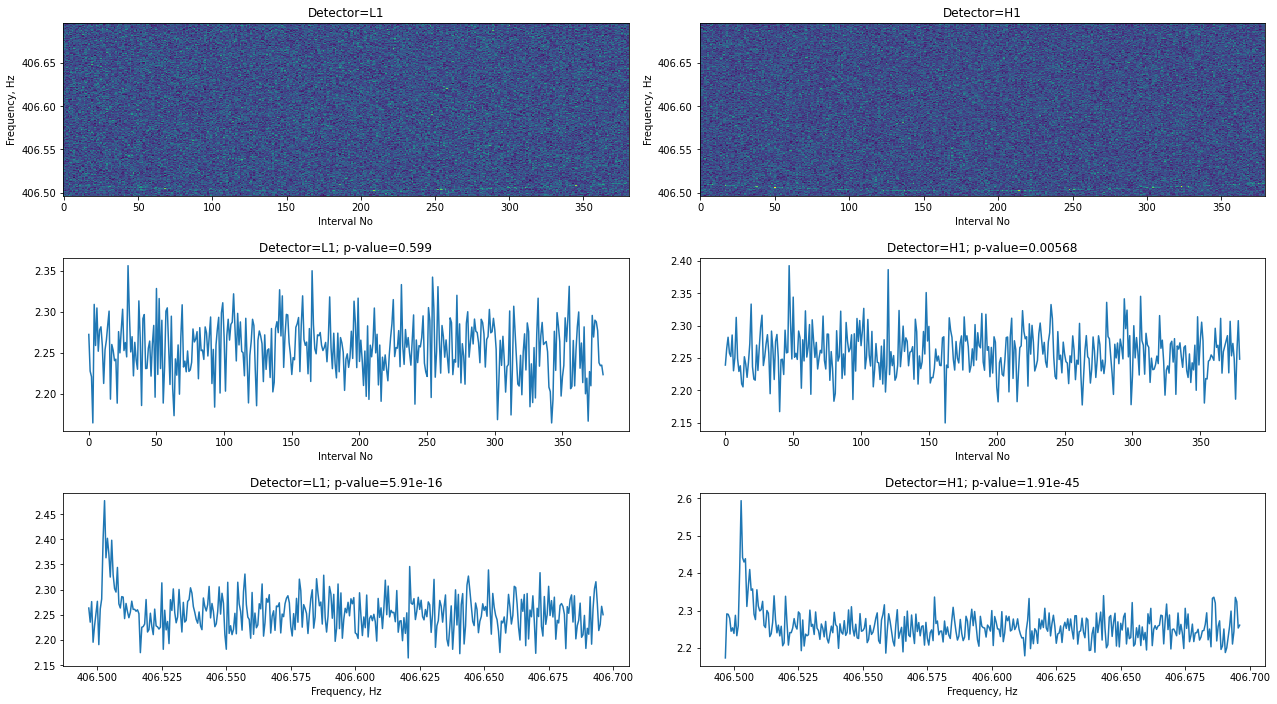

In [12]:
test_record_view(id=7850)

* It can be seen from the upper two graphs, that this record does contain the signal (line at the bottom).
* From the middle two graphs we can see, that the noise is likely to be stationary at L1 and non-stationary at H1 (p-value is about 0.006).
* From the bottom graphs we can say, it is completly non-gaussian. The record may contain a signal.

Conclusion: **the record may contain a signal. We must pay attention to it.**

## 3.3) `id`=3283

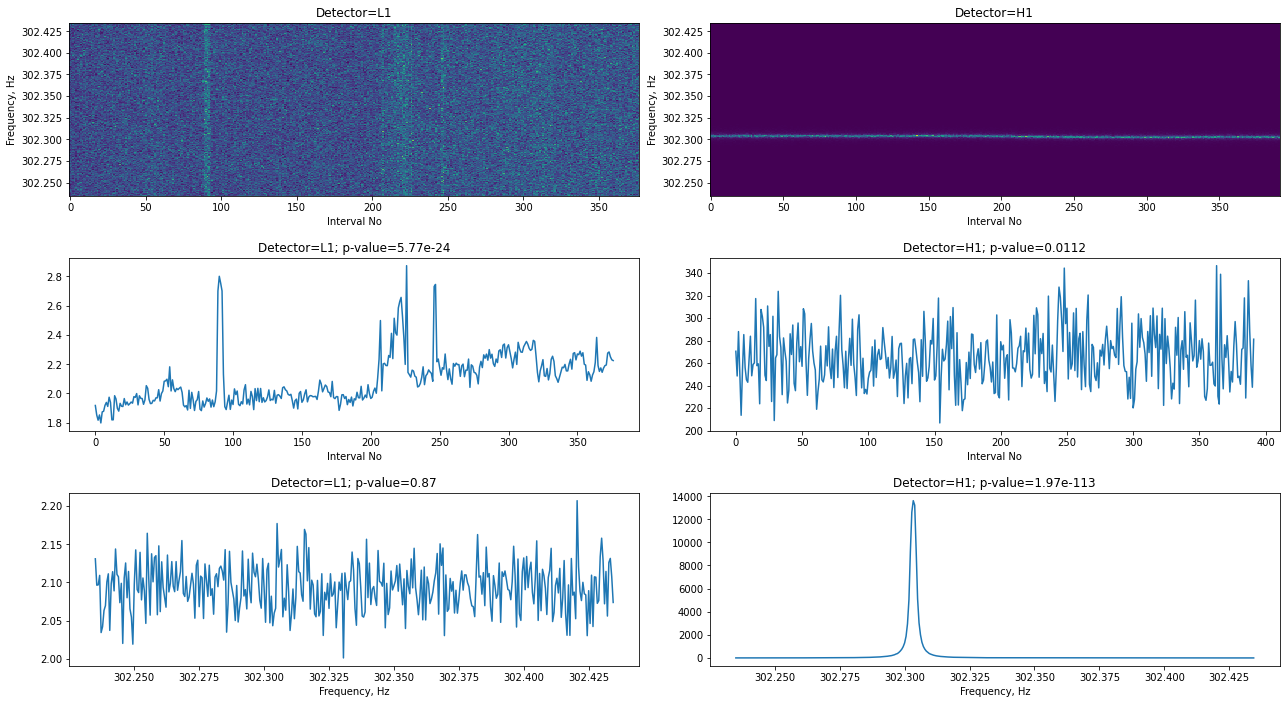

In [13]:
test_record_view(id=3283)

* We can't see the signal on the left upper graph. The right upper graph is something strange, because the signal is to strong. Also it doesn't have frequency gradient, so it may be just (electrical?) interference. If we had such strong signal on H1, we must had definitely registered it at L1, too. But this is not the case.
* From the middle left graph we can see, that the noise is not stationary at L1. The p-value is also low fow H1, but we need to exclude the interference first to make a conclusion here.
* From the bottom graphs we can clearly see the interference at H1.

Conclusion: **the record may or may not contain a signal. But it definitely contains interference that should not be confused with it.**

## 3.4) `id`=8100

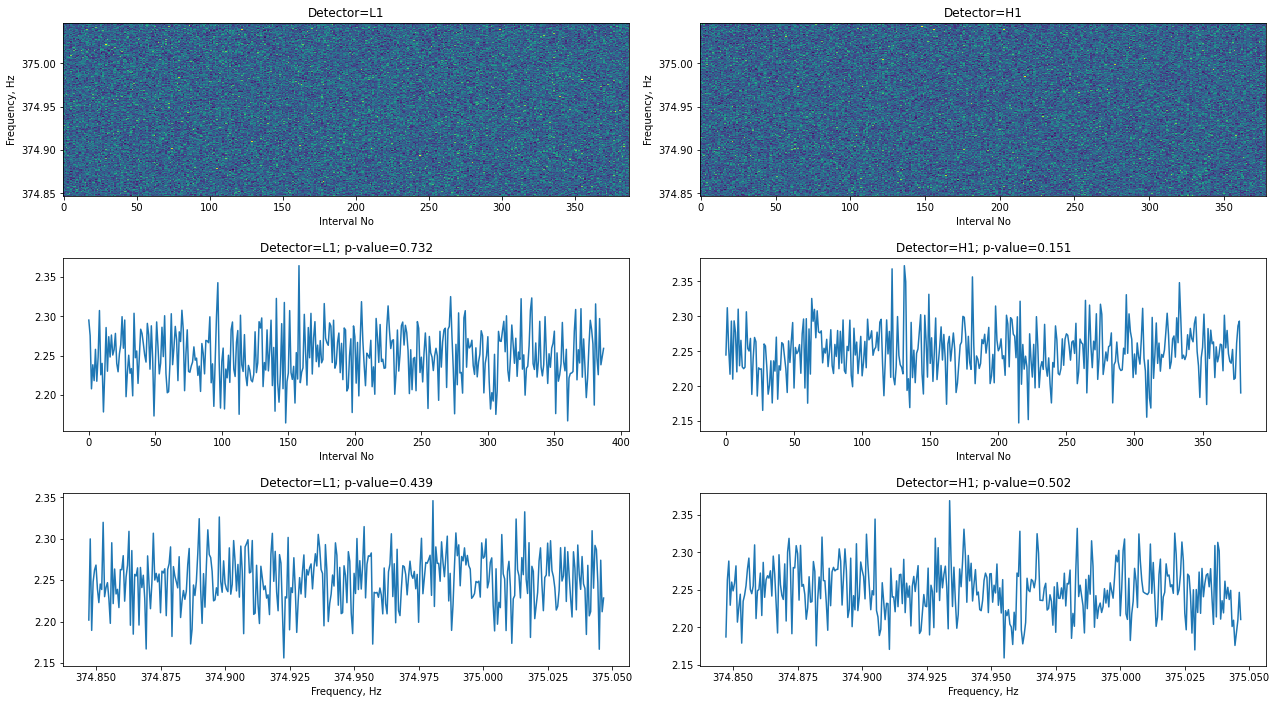

In [14]:
test_record_view(id=8100)

This is the record from the train set. 
All the graphs say the same thing: **the record looks like white noise, and me have to investigate it further**.

In [20]:
def extract_data_from_hdf5(path, labels):
    '''
    Extracts data from hdf5 file and puts it into a dict. It also adds the label
    '''
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Livingston decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data
    
def plot_spectograms(data):
    '''
    Shows the real and imaginary amplitudes of the SFTs as spectograms for both detectors
    '''
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Label {data['label']}")

    for ind, detector in enumerate(['L1', 'H1']):
        ax[ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        
        c0 = ax[ind][0].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].real)
        c1 = ax[ind][1].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].imag)
    
        fig.colorbar(c0, ax=ax[ind][0])
        fig.colorbar(c1, ax=ax[ind][1])
        
    plt.show()

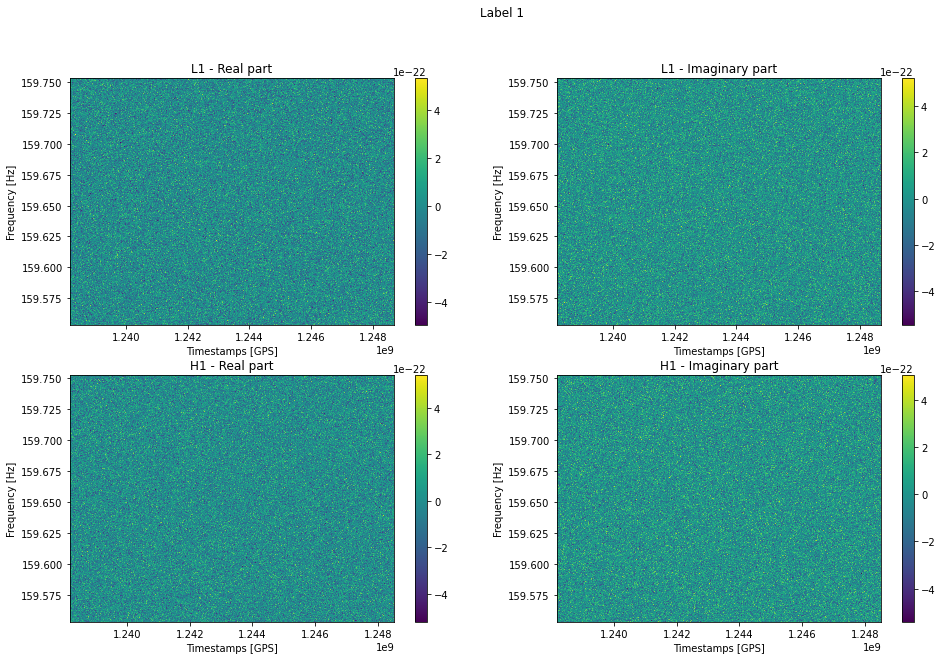

In [26]:
sns.reset_orig() 
data = extract_data_from_hdf5(train_example_with_signal_path, df)
plot_spectograms(data)

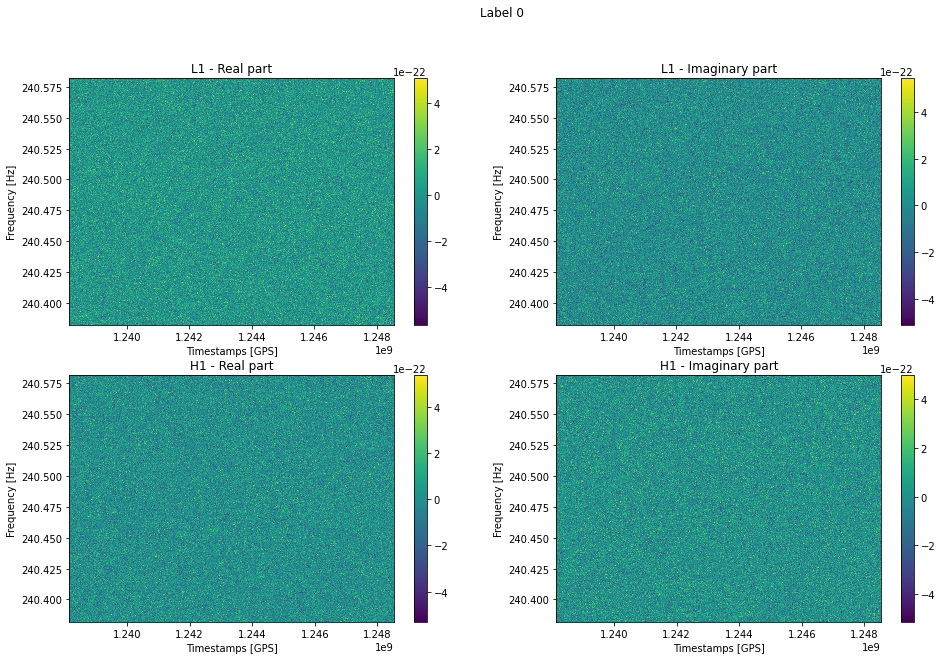

In [27]:
data = extract_data_from_hdf5(train_example_without_signal_path, df)
plot_spectograms(data)

In [30]:
#TIME ANALYSIS
H1_timestamps, L1_timestamps, start_diff, labels, freq = ([] for i in range(5))

for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    id_ = p.split('.')[0]
    labels.append(df.loc[df.id==id_].target.item())
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, df)
    L1_timestamps.append(data['L1_ts'])
    H1_timestamps.append(data['H1_ts'])
    start_diff.append(data['L1_ts'][0] - data['H1_ts'][0])
    freq.append(data['freq'])

  0%|          | 0/603 [00:00<?, ?it/s]

In [31]:
df = pd.DataFrame({'label':labels, 'L1_timestamp_length':[len(i) for i in L1_timestamps], 'H1_timestamp_length':[len(i) for i in H1_timestamps], 'Differnce in start time between detectors':start_diff})
df = df[df.label!=-1]

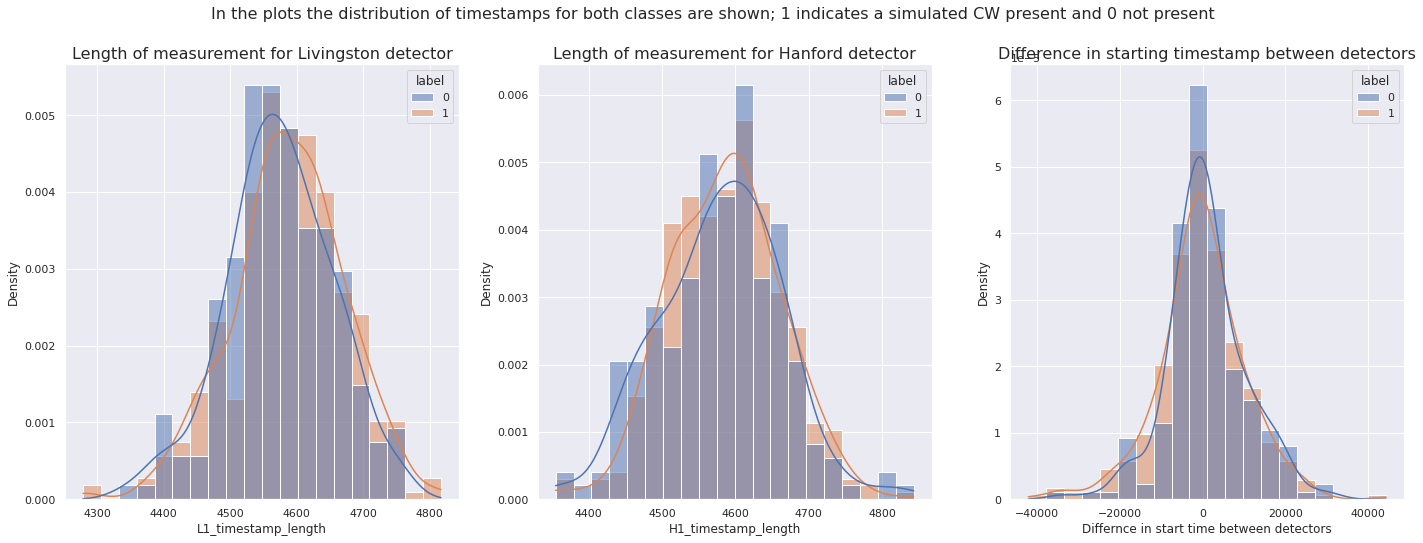

In [32]:
sns.set_theme()

fig, ax = plt.subplots(1,3, figsize=(24,8))
fig.suptitle(f"In the plots the distribution of timestamps for both classes are shown; 1 indicates a simulated CW present and 0 not present", fontsize=16)
sns.histplot(
        df, x="L1_timestamp_length", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[0], kde=True).set_title('Length of measurement for Livingston detector', fontsize=16);

sns.histplot(
        df, x="H1_timestamp_length", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[1], kde=True).set_title('Length of measurement for Hanford detector', fontsize=16);

sns.histplot(
        df, x="Differnce in start time between detectors", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[2], kde=True).set_title('Difference in starting timestamp between detectors', fontsize=16);

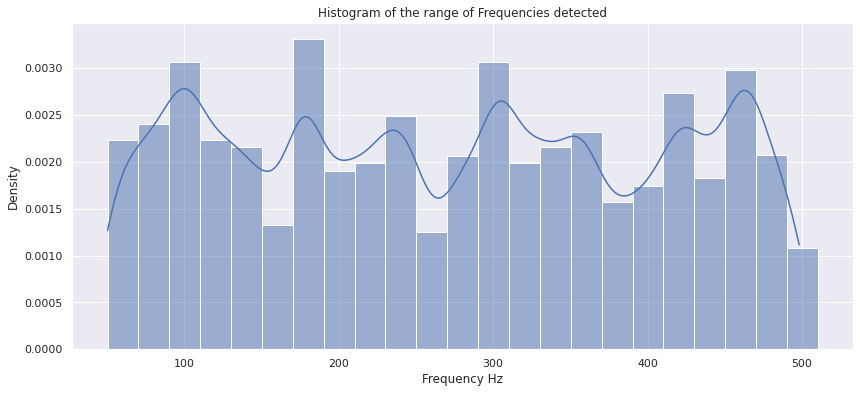

In [33]:
plt.figure(figsize=(14,6))
sns.histplot(x=list(np.hstack(freq)), binwidth=20, stat="density", common_norm=False, bins=40, kde=True)
plt.title('Histogram of the range of Frequencies detected');
plt.xlabel('Frequency Hz')
plt.show()

# 4) Process all records

Now we do the same, but with all records and without plots. Then we'll compare the results for train and test sets.

In [34]:
def test_record(id):
    ma_sft, freqs = get_MA_SFT(id)

    results = {'freq' : freqs[0]}
    
    for detector in ['L1', 'H1']:
        results[detector] = []
        for row in range(2):
            # Calculate mean value for each frequency or for each time interval
            x = np.mean(ma_sft[detector], axis=row)
            k2, p = stats.normaltest(x)
            results[detector].append(p)
            
    return [results['freq']] + results['L1'] + results['H1']

In [38]:
# Add zero-filled columns to our dataframe
columns = ['freq', 'L1_time', 'L1_freq', 'H1_time', 'H1_freq']
df[columns] = 0

# Now calculate p-values and put it inside the dataframe
for id in range(len(df)):
    if id % 100 == 0: 
        print(f'Processing #{id}')
    df.loc[id, columns] = test_record(id)
    
df.head()

# 5) Finally, let's display some statistics

We introduse some `treshold` and a set of criteria, when we reject the particulra null hypothesis. All is put into one function

In [ ]:
def print_criteria_statistics(ds, treshold=0.01):
    # A set of criteria for every column
    criteria = [df[col]<treshold for col in columns[1:]]
    
    # A dict of criteria for datasets
    criteria_ds = {'train' : df.target != 0.5, 'test': df.target == 0.5}

    # Total length
    total = len(df[criteria_ds[ds]])

    print(f'Dataset = {ds}; length = {total}')
    print('-'*80)

    for n, col in enumerate(columns[1:]):
        l = len(df[criteria_ds[ds] & criteria[n]])
        print(f'{col}  is not gauss for\t{l}/{total},\twhich is {100*l/total:.3}%')

    print('-'*80)

    l = len(df[criteria_ds[ds] & criteria[0] & criteria[2]])
    print(f'Time L&H is not gauss for\t{l}/{total},\twhich is {100*l/total:.3}%')

    l = len(df[criteria_ds[ds] & criteria[1] & criteria[3]])
    print(f'Freq L&H is not gauss for\t{l}/{total},\twhich is {100*l/total:.3}%')

    print('-'*80)

    l = len(df[criteria_ds[ds] & (criteria[0] | criteria[2])])
    print(f'Time L|H is not gauss for\t{l}/{total},\twhich is {100*l/total:.3}%')

    l = len(df[criteria_ds[ds] & (criteria[1] | criteria[3])])
    print(f'Freq L|H is not gauss for\t{l}/{total},\twhich is {100*l/total:.3}%')

Now, display the results

In [ ]:
print_criteria_statistics(ds = 'train')

print('\n')

print_criteria_statistics(ds = 'test')

It's interesting! So...
* **Stationarity.**

In the train set we never have non stationary noise on both detectors simultaniously, and only in 3.5% we have it on one of the detectors.
In the test set we have it on both detectors in 11.2% and on at least one of them in 21.3%.

* **Frequency "artifacts"**

These artifacts could be potential signals or a glitches, or an interferences.
In the train set we have it in 7% on the both detectors and in 15% on at least one of them. In the test the corresponding values are 1.9% and 8.8%. 

Now let's set even less value for the `treshold` and look, what happens.

In [ ]:
print_criteria_statistics(ds = 'train', treshold=1e-5)

print('\n')

print_criteria_statistics(ds = 'test', treshold=1e-5)

We can see, that now all train signals look stationary (speaking corectly, we don't reject our null hypothesis), and 18.5% of test signals not. But the most interesting is that frequency artifacts are not independent on both detectors. If it was so, than, for test set, we'll have 0.0176*0.0406 = 0.07% of not gauss 'Freq L&H', but we have 1.17%. So, almost all of the records with not gauss 'Freq L&H' (we have selected 93 of them) are likely to contain a signal.

Let's get their exact ids and look at them to see, if it's true.

# 6) Investigating not gaussian 'Freq L&H'

Let's look at, say, first 5 candidates

In [ ]:
treshold = 1e-5

candidates = df[(df.target==0.5) & (df.L1_freq<treshold) & (df.H1_freq<treshold)].index.tolist()

for n in candidates[:5]:
    print(f'Candidate {n}')
    test_record_view(id=n)

The first one (#50) is very interesting! On L1 detector we see the increasing frequency, and on H1 detector it is different and approximately constant. So, we may deal with the signal and the interference at the same time))
When looking carefully we can also see the small peak near 250.1Hz on H1 detector, which may correspond to the signal on L1.

Other 4 records have approximately the same frequencies of peaks on L1 and H1.

You may notice, that if the signal frequency varies a lot, it doesn't affect the average power spectrum much. This signal will be definitely lost with the proposed approach. So, to conclude, there's much work, and we must be very carefull with the signals we have. 